In [1]:
# Minimal requirements (Colab usually has them, but keep for reproducibility)
!pip install -q numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass


In [2]:
@dataclass
class Obstacle:
    center: np.ndarray  # shape (2,)
    radius: float

# Start & goal
start = np.array([0.0, 0.0], dtype=np.float64)
goal  = np.array([10.0, 0.0], dtype=np.float64)

# Obstacles (feel free to tweak/extend)
obstacles = [
    Obstacle(center=np.array([4.0, 0.5]), radius=0.8),
    Obstacle(center=np.array([6.0, -0.4]), radius=0.7),
]

# Optimization hyperparameters
num_ctrl_points = 14           # total points including start & goal
lr = 0.05                      # learning rate for Adam
num_steps = 1200               # optimization iterations
lambda_length = 1.0            # weight for squared-length term
lambda_smooth = 0.1            # weight for smoothness (second-difference) term
w_obs = 0.05                   # weight for obstacle repulsion
eps = 1e-6                     # small epsilon for numerical stability
seed = 42                      # reproducibility
np.random.seed(seed)


In [3]:
def initialize_path(start, goal, n):
    """Linear initialization with small random wobble on interior points."""
    xs = np.linspace(start[0], goal[0], n)
    ys = np.linspace(start[1], goal[1], n)
    P = np.stack([xs, ys], axis=1)
    # add tiny noise to interior points to break symmetry
    P[1:-1] += 0.05 * np.random.randn(n-2, 2)
    P[0] = start
    P[-1] = goal
    return P

def plot_path(P_init, P_opt, obstacles, title="Path optimization"):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(P_init[:,0], P_init[:,1], '--o', label='Initial path')
    ax.plot(P_opt[:,0], P_opt[:,1], '-o',  label='Optimized path')
    # draw obstacles
    for obs in obstacles:
        circ = plt.Circle(obs.center, obs.radius, fill=False, linestyle='--')
        ax.add_patch(circ)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle=':')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    return fig, ax

P0 = initialize_path(start, goal, num_ctrl_points)


In [4]:
def objective_and_grad(P, obstacles, lambda_length, lambda_smooth, w_obs, eps):
    """
    Compute objective and gradient w.r.t. interior points P[1:-1].
    P shape: (N, 2)
    """
    N = P.shape[0]
    # convenience
    d = P[1:] - P[:-1]                       # segment differences
    length_sq = np.sum(np.sum(d*d, axis=1))  # sum of squared lengths

    # smoothness second difference (for i=1..N-2)
    dd = P[2:] - 2*P[1:-1] + P[:-2]
    smooth = np.sum(np.sum(dd*dd, axis=1))

    # obstacle penalty on interior points only
    obs_pen = 0.0
    for obs in obstacles:
        vec = P[1:-1] - obs.center  # shape (N-2, 2)
        dist2 = np.sum(vec*vec, axis=1) + eps
        obs_pen += np.sum(1.0 / dist2)

    # total objective
    J = lambda_length * length_sq + lambda_smooth * smooth + w_obs * obs_pen

    # gradient initialization
    G = np.zeros_like(P)

    # ---- gradient of length_sq term: 2*(2p_i - p_{i-1} - p_{i+1}), interior only
    # For i=1..N-2
    G[1:-1] += 2*lambda_length * (2*P[1:-1] - P[:-2] - P[2:])

    # ---- gradient of smoothness term (discrete biharmonic): convolution with [1, -4, 6, -4, 1]
    # Handle interior i with neighbors up to distance 2
    # g_i += 2*lambda_smooth * (6*p_i -4*(p_{i-1}+p_{i+1}) + (p_{i-2}+p_{i+2}))
    G[2:-2] += 2*lambda_smooth * (6*P[2:-2] - 4*(P[1:-3] + P[3:-1]) + (P[0:-4] + P[4:]))

    # Edge-adjacent (i=1 and i=N-2) have truncated stencil
    if N >= 4:
        i = 1
        G[i] += 2*lambda_smooth * (6*P[i] - 4*(P[i-1] + P[i+1]) + (P[i+2]))  # no p_{i-2}
        i = N-2
        G[i] += 2*lambda_smooth * (6*P[i] - 4*(P[i-1] + P[i+1]) + (P[i-2]))  # no p_{i+2}

    # ---- gradient of obstacle penalty: d/dp  sum 1/(||p-c||^2+eps) = -2*(p-c)/(||p-c||^2+eps)^2
    for obs in obstacles:
        vec = P[1:-1] - obs.center             # shape (N-2, 2)
        dist2 = np.sum(vec*vec, axis=1) + eps  # shape (N-2,)
        denom = (dist2**2)[:, None]
        G[1:-1] += w_obs * (-2.0) * (vec / denom)

    # Fix endpoints (no gradient update on p0 and p_{N-1})
    G[0] = 0.0
    G[-1] = 0.0

    return J, G


In [5]:
class Adam:
    def __init__(self, shape, lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8):
        self.m = np.zeros(shape)
        self.v = np.zeros(shape)
        self.t = 0
        self.lr = lr
        self.b1 = beta1
        self.b2 = beta2
        self.eps = eps

    def step(self, params, grad):
        self.t += 1
        self.m = self.b1 * self.m + (1 - self.b1) * grad
        self.v = self.b2 * self.v + (1 - self.b2) * (grad * grad)
        mhat = self.m / (1 - self.b1**self.t)
        vhat = self.v / (1 - self.b2**self.t)
        return params - self.lr * mhat / (np.sqrt(vhat) + self.eps)

# copy initial path
P = P0.copy()
opt = Adam(shape=P.shape, lr=lr)

history = []
for step in range(1, num_steps+1):
    J, G = objective_and_grad(P, obstacles, lambda_length, lambda_smooth, w_obs, eps)
    # update only interior points
    P[1:-1] = opt.step(P, G)[1:-1]
    # keep endpoints fixed
    P[0] = start
    P[-1] = goal
    if step % 50 == 0:
        history.append(J)
        # optional: print progress every 200 steps
        if step % 200 == 0:
            print(f"step={step:4d}  objective={J:.6f}")

P_opt = P.copy()


step= 200  objective=9.217983
step= 400  objective=9.217911
step= 600  objective=9.217911
step= 800  objective=9.217907
step=1000  objective=9.217911
step=1200  objective=9.217908


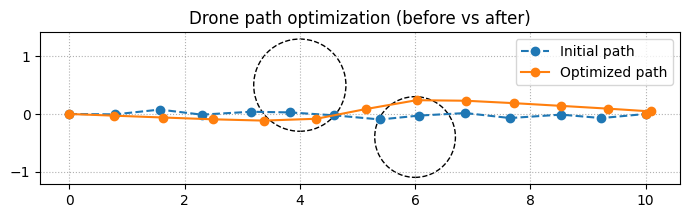

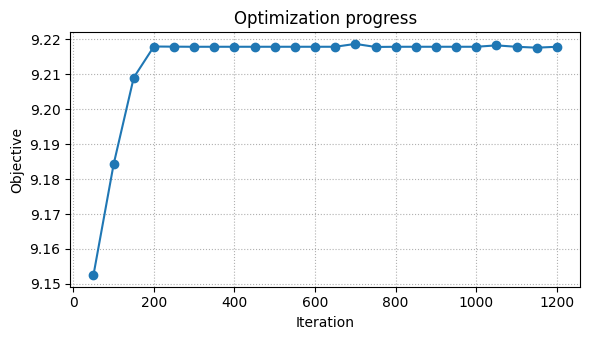

Saved: outputs_path_before_after.png, outputs_objective_curve.png, optimized_path.npy


In [6]:
# Plot and save path comparison
fig, ax = plot_path(P0, P_opt, obstacles, title="Drone path optimization (before vs after)")
fig.savefig("outputs_path_before_after.png", dpi=160)
plt.show()

# Plot objective history (optional)
if len(history) > 0:
    plt.figure(figsize=(6,3.5))
    plt.plot(np.arange(50, 50*len(history)+1, 50), history, '-o')
    plt.xlabel("Iteration")
    plt.ylabel("Objective")
    plt.title("Optimization progress")
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.savefig("outputs_objective_curve.png", dpi=160)
    plt.show()

# Save optimized path points
np.save("optimized_path.npy", P_opt)
print("Saved: outputs_path_before_after.png, outputs_objective_curve.png, optimized_path.npy")


In [7]:
# Example tweak (optional): add a third obstacle and re-run few iterations
# obstacles.append(Obstacle(center=np.array([8.0, 0.2]), radius=0.6))
# for _ in range(300):
#     J, G = objective_and_grad(P, obstacles, lambda_length, lambda_smooth, w_obs, eps)
#     P[1:-1] = opt.step(P, G)[1:-1]
# P_tweaked = P.copy()
# fig, ax = plot_path(P_opt, P_tweaked, obstacles, title="With extra obstacle (illustrative)")
# fig.savefig("outputs_with_extra_obstacle.png", dpi=160)
# plt.show()
